# RentSmart Dataset

The RentSmart dataset provides detailed insight on inspection services in Boston from 2016 to 2024, focusing on building, housing, health, and environmental regulations. This dataset allows analysis on violations and property conditions. More information can be found via the following link: https://data.boston.gov/dataset/rentsmart. 
This dataset will also be used to analyze housing prices and taxes in District 7, comparing them to broader city trends.

In this notebook, we will...

- Clean and pre-process the dataset
- Conduct base analysis on the dataset
- Collect useful insights on housing violations in District 7 from 2019 to 2024, which is the time range slightly before the Councilor was elected and is in office as the client requested us to focus on

In the upcoming weeks, this notebook will also help us compare the District's performance with the city of Boston.

In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import pytz
import csv
import fiona

In [14]:
df = pd.read_csv("../data/all-rentsmart.csv")

## Data Cleaning

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344553 entries, 0 to 344552
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            344553 non-null  object 
 1   violation_type  344553 non-null  object 
 2   description     344539 non-null  object 
 3   address         344553 non-null  object 
 4   neighborhood    344537 non-null  object 
 5   zip_code        344553 non-null  int64  
 6   parcel          344553 non-null  int64  
 7   owner           344553 non-null  object 
 8   year_built      342044 non-null  float64
 9   year_remodeled  222307 non-null  float64
 10  property_type   344553 non-null  object 
 11  latitude        344553 non-null  float64
 12  longitude       344553 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 34.2+ MB


`year_remodeled` is missing around 40% of the values. Dropping all rows with `year_remodeled` missing will be getting rid of a lot of datapoints, so we decide to not drop any data.

In [16]:
df

,date,violation_type,description,address,neighborhood,zip_code,parcel,owner,year_built,year_remodeled,property_type,latitude,longitude
0,2024-11-19 00:00:00+00,Enforcement Violations,Improper storage trash: res,"741 E Sixth St, 02127",South Boston,2127,604127001,EAST SIXTH LTD PARTNERSHIP MASS LP,1965.0,1990.0,Mixed Use (Res. and Comm.),42.333009,-71.030950
1,2024-11-19 00:00:00+00,Enforcement Violations,Overfilling of barrel/dumpster,"741 E Sixth St, 02127",South Boston,2127,604127001,EAST SIXTH LTD PARTNERSHIP MASS LP,1965.0,1990.0,Mixed Use (Res. and Comm.),42.333009,-71.030950
2,2024-11-19 00:00:00+00,Enforcement Violations,Improper storage trash: res,"92-94 Esmond St, 02121",Dorchester,2121,1402690000,WAYNE AT BICKNELL LLC,1920.0,2018.0,Residential 7 or more units,42.296860,-71.083371
3,2024-11-19 00:00:00+00,Enforcement Violations,Improper storage trash: res,"84 Esmond St, 02121",Dorchester,2121,1402692000,ALLEN & HANDY INVESTMENTS LLC,1895.0,2010.0,Residential 3-family,42.297150,-71.083501
4,2024-11-19 00:00:00+00,Enforcement Violations,Improper storage trash: res,"7 Aberdeen St, 02215",Boston,2215,2100139000,SEVEN 21 ABERDEEN STREET,1999.0,1999.0,Condominium Main*,42.346420,-71.104031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344548,2019-12-16 13:21:00+00,Housing Complaints,Building Inspection Request,"34 Mayfield St, 02125",Dorchester,2125,1302039000,FIDALGO PEDRO C,1905.0,NaN,Residential 3-family,42.316390,-71.058451
344549,2019-12-16 13:10:00+00,Housing Complaints,Building Inspection Request,"4 Edson Ter, 02136",Hyde Park,2136,1812520007,KELLY VINCENT C,1960.0,NaN,Residential 2-family,42.242470,-71.138281
344550,2019-12-16 13:04:00+00,Housing Complaints,Unsafe Dangerous Conditions,"22 Fessenden St, 02126",Mattapan,2126,1800858000,BARNES SHEILA,1920.0,2006.0,Residential 2-family,42.278850,-71.092021
344551,2019-12-16 13:01:00+00,Housing Complaints,Pest Infestation - Residential,"1450 Blue Hill Ave #2, 02126",Mattapan,2126,1800941000,TRANSTAMAR JEAN P,1905.0,1990.0,Residential 3-family,42.274480,-71.093231


### Convert UTC timezone to Eastern Time

In [17]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='mixed')
boston_tz = pytz.timezone("America/New_York")
df['date'] = df['date'].apply(lambda x: x.astimezone(boston_tz) if not pd.isna(x) else None)

### Convert `year_built` and `year_remodeled` to int

In [18]:
df['year_remodeled'] = df['year_remodeled'].astype(pd.Int64Dtype())
df['year_built'] = df['year_built'].astype(pd.Int64Dtype())

### Format `zip_code` to string and padding the front with zero

In [19]:
df["zip_code"] = df["zip_code"].astype(str).str.zfill(5)

### Consolidate values in `description` that may be mispelled or a duplication of each other

In [20]:
df["violation_type"].sort_values().unique()

array(['Building Violations', 'Civic Maintenance Requests',
       'Enforcement Violations', 'Housing Complaints',
       'Housing Violations', 'Sanitation Requests'], dtype=object)

In [21]:
df["description"].sort_values().unique()

array(['A door leading from a residence to the exterior shall be weathertight.',
       'Abandoned Bicycle', 'Abandoned Building', 'Abandoned Vehicles',
       'Access for Repairs and Alterations - Every occ. of a dwelling, dwelling/rooming unit shall give the owner thereof, or his agent or employees, upon reasonable notice, reasonable access, if possible by appt, to the dwelling, dwelling/rooming unit for the purpose of making such repairs or alterations.',
       'Access to Public Way', 'Accessible Means of Egress',
       'Accessory keeping of hens', 'Acts 1956 as Amended',
       'Address Identification', 'Adjacent to Excavations',
       'All devices that combust fuel shall be properly vented to the outdoors. Electric and gas dryers shall be vented to the outdoors.Electric range hoods shall be vented to the outdoors.',
       'All guards and balusters must be placed at required intervals.',
       'All homeless shelters shall comply with 105. CMR 410.000 with the exception stated 

In [22]:
replace_dict = {
    "Work w/out Permit": "Work Without Permit",
    "Work without permit": "Work Without Permit",
    "Working Without a Permit": "Work Without Permit",
    "Working Without Electrical Permit": "Work Without Permit", 
    "Unregistered motor vehicles-1": "Unregistered motor vehicles - 1",
    "Unregistered motor vehicles- 2": "Unregistered motor vehicles - 2",
    "The owner shall provide the electricity or gas used in each dwelling unit unless: the utility is seperated and there is a written rental agreement.":
       "The owner shall provide the electricity or gas used in each dwelling unit unless: the utility is seperated and there is a written rental agreement",
    "Residences containing one dwelling unit:(1) The occupant shall maintain the unit free from all pest infestation and shall be responsible for pest elimination. (2) The owner has not maintained structural or other building elements necessary to keep pests from entering.":
        "Residences containing one dwelling unit: (1) The occupant shall maintain the unit free from all pest infestation and shall be responsible for pest elimination.  (2) The owner has not maintained structural or other building elements necessary to keep pests from entering.",
    "Removal snow private prop": "Removal snow private property",
    "Protection of Adj. Property": "Protection of Adjoining Property",
    "Large building recycling- 1": "Large building recycling - 1",
    "Illegal dumping 5 cubic yd.": "Illegal dumping 1-5 cubic yd.",
    "Illegal dumping 1-5 cubic yd.:": "Illegal dumping 1-5 cubic yd.",
    "Failure clear sidewalk - snow:": "Failure clear sidewalk - snow",
    "Every owner of a residence shall provide to each occupant or post the Notice of Occupants’ Legal Rights and Responsibilities.": "Every owner of a residence shall provide to each occupant or post the Notice of Occupants' Legal Rights and Responsibilities."    
}

df['description'] = df['description'].replace(replace_dict)

## Determine addresses in District 7 from City Council District shapefile
Use the coordinates of address that's given by `latitude` and `longitude` column to compare against the shapefile. Add a new column called `is_d7` to the dataframe. If the coordinates is in the boundary of District 7's polygon, `is_df` is True. If not, set the column value to False.

In [23]:
district_shapefile = gpd.read_file("../data/City-Council-District")

In [24]:
count = 0
is_D7_addresses = []

for row in df.itertuples(index=True, name="Row"):
    address_point = Point(row.longitude, row.latitude)
    address_gdf = gpd.GeoDataFrame(geometry=[address_point], crs="EPSG:4326")
    address_gdf = address_gdf.to_crs(district_shapefile.crs)
    result = gpd.sjoin(address_gdf, district_shapefile, how="left", predicate="intersects")

    if result['DISTRICT'].values[0] == 7:
        count += 1
        is_D7_addresses.append(True)
    else:
        is_D7_addresses.append(False)

print(f"{count} reports are recorded on RentSmart that is from housing in District 7.")

40340 reports are recorded on RentSmart that is from housing in District 7.


In [25]:
df['is_d7'] = is_D7_addresses

### Add a column to indicate catchment area boundary as specified by the client
The column is named `d7_catchment_area` which reflects the different neighborhood entities such as Neighborhood Association and residential areas of District 7. This file is prepared by the client and is given to us in the form of a customer Google map, which can be found [here](https://www.google.com/maps/d/u/0/viewer?hl=en&mid=1oQGNssM23sJJ8gvXTGcMG6uQD3jwArQ&ll=42.34100795613036%2C-71.0578151460057&z=14).

We export the map as KML file and convert each later to a shapefile, which can be found in /data/D7-Catchment-Area folder.

Combine all shapefile layers into the same shapefile.

In [26]:
file_path = "../data/D7-Catchment-Area/"
layers = fiona.listlayers(file_path)
shapefile = {layer: gpd.read_file(file_path, layer=layer) for layer in layers}
d7_catchment_gdf = gpd.GeoDataFrame(pd.concat(shapefile.values(), ignore_index=True))
d7_catchment_gdf = d7_catchment_gdf.to_crs("EPSG:4326")

In [27]:
d7_catchment_area = []

for row in df.itertuples(index=True, name="Row"):
    address_point = Point(row.longitude, row.latitude)
    address_gdf = gpd.GeoDataFrame(geometry=[address_point], crs="EPSG:4326")
    address_gdf = address_gdf.to_crs(d7_catchment_gdf.crs)
    result = gpd.sjoin(address_gdf, d7_catchment_gdf, how="left", predicate="intersects")

    d7_catchment_area.append(result["Name"].values[0])

In [28]:
df["d7_catchment_area"] = d7_catchment_area

In [29]:
df["d7_catchment_area"] = df["d7_catchment_area"].replace(
    'Holborn, Gannett, Gaston, Otisfield Betterment Association\xa0',
    'Holborn, Gannett, Gaston, Otisfield Betterment Association',
    regex=False
)

### Verify `neighborhood` columns
- Neighborhood may have been selected at the time of reporting based on the inspector's perceived location, which may not be the actual neighborhood. The neighborhood boundaries shapefile estimated by census tract from Boston Planning & Development Agency (BDPA) help us verify the provided values in `neighborhood` columns and impute columns where the value is missing or where the value is vague.

In [30]:
print(f"There are {df[df["neighborhood"] == "Boston"].shape[0]} rows where the neighborhood is simply listed as Boston.")

There are 66025 rows where the neighborhood is simply listed as Boston.


In [31]:
neighborhood_shapefile = gpd.read_file("../data/bpda_neighborhood_boundaries")

In [32]:
new_neighborhood = []

for row in df.itertuples(index=True, name="Row"):
    address_point = Point(row.longitude, row.latitude)
    address_gdf = gpd.GeoDataFrame(geometry=[address_point], crs="EPSG:4326")
    address_gdf = address_gdf.to_crs(neighborhood_shapefile.crs)
    result = gpd.sjoin(address_gdf, neighborhood_shapefile, how="left", predicate="intersects")

    new_neighborhood.append(result["name"].values[0])

In [34]:
df["neighborhood"] = new_neighborhood

Only run this cell when exporting the cleaned dataframe to a CSV file. This new file will be used in Looker Studio for dashboard visualization.

In [35]:
df.to_csv("../data/all-rentsmart-cleaned.csv", index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

## Visualization

### Total violations

In [48]:
violation_type_description = df.groupby("violation_type")["description"].value_counts().reset_index(name="count")
violation_type_description["percentage"] = (
    violation_type_description["count"]
    / violation_type_description.groupby("violation_type")["count"].transform("sum")
) * 100


In [49]:
def group_others(data, threshold=3):
    others = data[data["percentage"] < threshold].sum(numeric_only=True)
    others_row = pd.DataFrame({
        "violation_type": [data["violation_type"].iloc[0]],
        "description": ["Others"],
        "count": [others["count"]],
        "percentage": [others["percentage"]]
    })
    data = data[data["percentage"] >= threshold]
    return pd.concat([data, others_row], ignore_index=True)

In [50]:
grouped_description = (
    violation_type_description.groupby("violation_type", group_keys=False)
    .apply(group_others)
    .reset_index(drop=True)
)

/var/folders/7y/58r1nbq91psb3zbw1k0f7bzc0000gn/T/ipykernel_61581/2046110081.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(group_others)


In [51]:
grouped_description

,violation_type,description,count,percentage
0,Building Violations,Failure to Obtain Permit,1000.0,31.615555
1,Building Violations,Maintenance,557.0,17.609864
2,Building Violations,Unsafe Structures,389.0,12.298451
3,Building Violations,Testing & Certification,387.0,12.235220
4,Building Violations,Unsafe and Dangerous,276.0,8.725893
5,Building Violations,Failed to comply w permit term,111.0,3.509327
6,Building Violations,Others,443.0,14.005691
7,Civic Maintenance Requests,Contractor Complaints,3169.0,54.106198
8,Civic Maintenance Requests,Catchbasin,1428.0,24.381082
9,Civic Maintenance Requests,Roadway Repair,625.0,10.670992


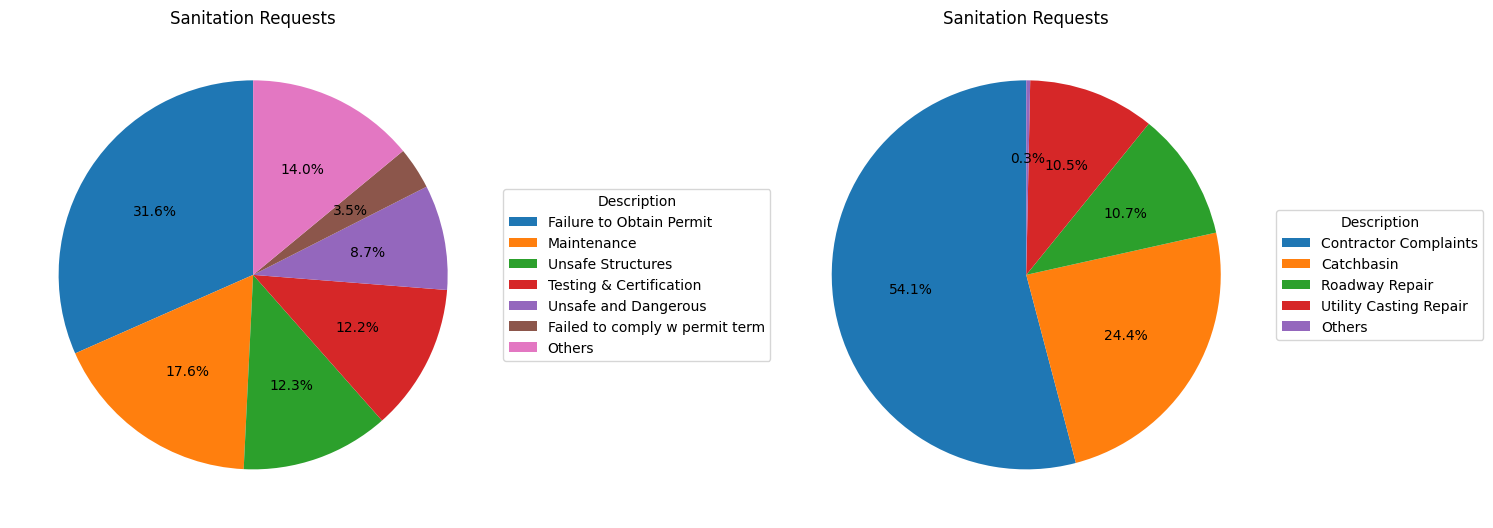

In [52]:
def wrap_labels(labels, width=80):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Get unique violation types
unique_violation_types = grouped_description["violation_type"].unique()

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.6])

ax1 = fig.add_subplot(gs[0, 0])
data = grouped_description[grouped_description["violation_type"] == unique_violation_types[0]]
wedges, texts, autotexts = ax1.pie(
    data["percentage"],
    labels=None,  # Hide labels directly on the pie chart
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 10},
)

wrapped_labels = wrap_labels(data["description"].tolist(), width=80)
ax1.set_title(f"{violation_type}", fontsize=12)
ax1.legend(
    wedges,
    wrapped_labels,
    title="Description",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
)


ax2 = fig.add_subplot(gs[0, 1])
data = grouped_description[grouped_description["violation_type"] == unique_violation_types[1]]
wedges, texts, autotexts = ax2.pie(
    data["percentage"],
    labels=None,  # Hide labels directly on the pie chart
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 10},
)

wrapped_labels = wrap_labels(data["description"].tolist(), width=80)
ax2.set_title(f"{violation_type}", fontsize=12)
ax2.legend(
    wedges,
    wrapped_labels,
    title="Description",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
)

plt.tight_layout(h_pad=3)
plt.show()

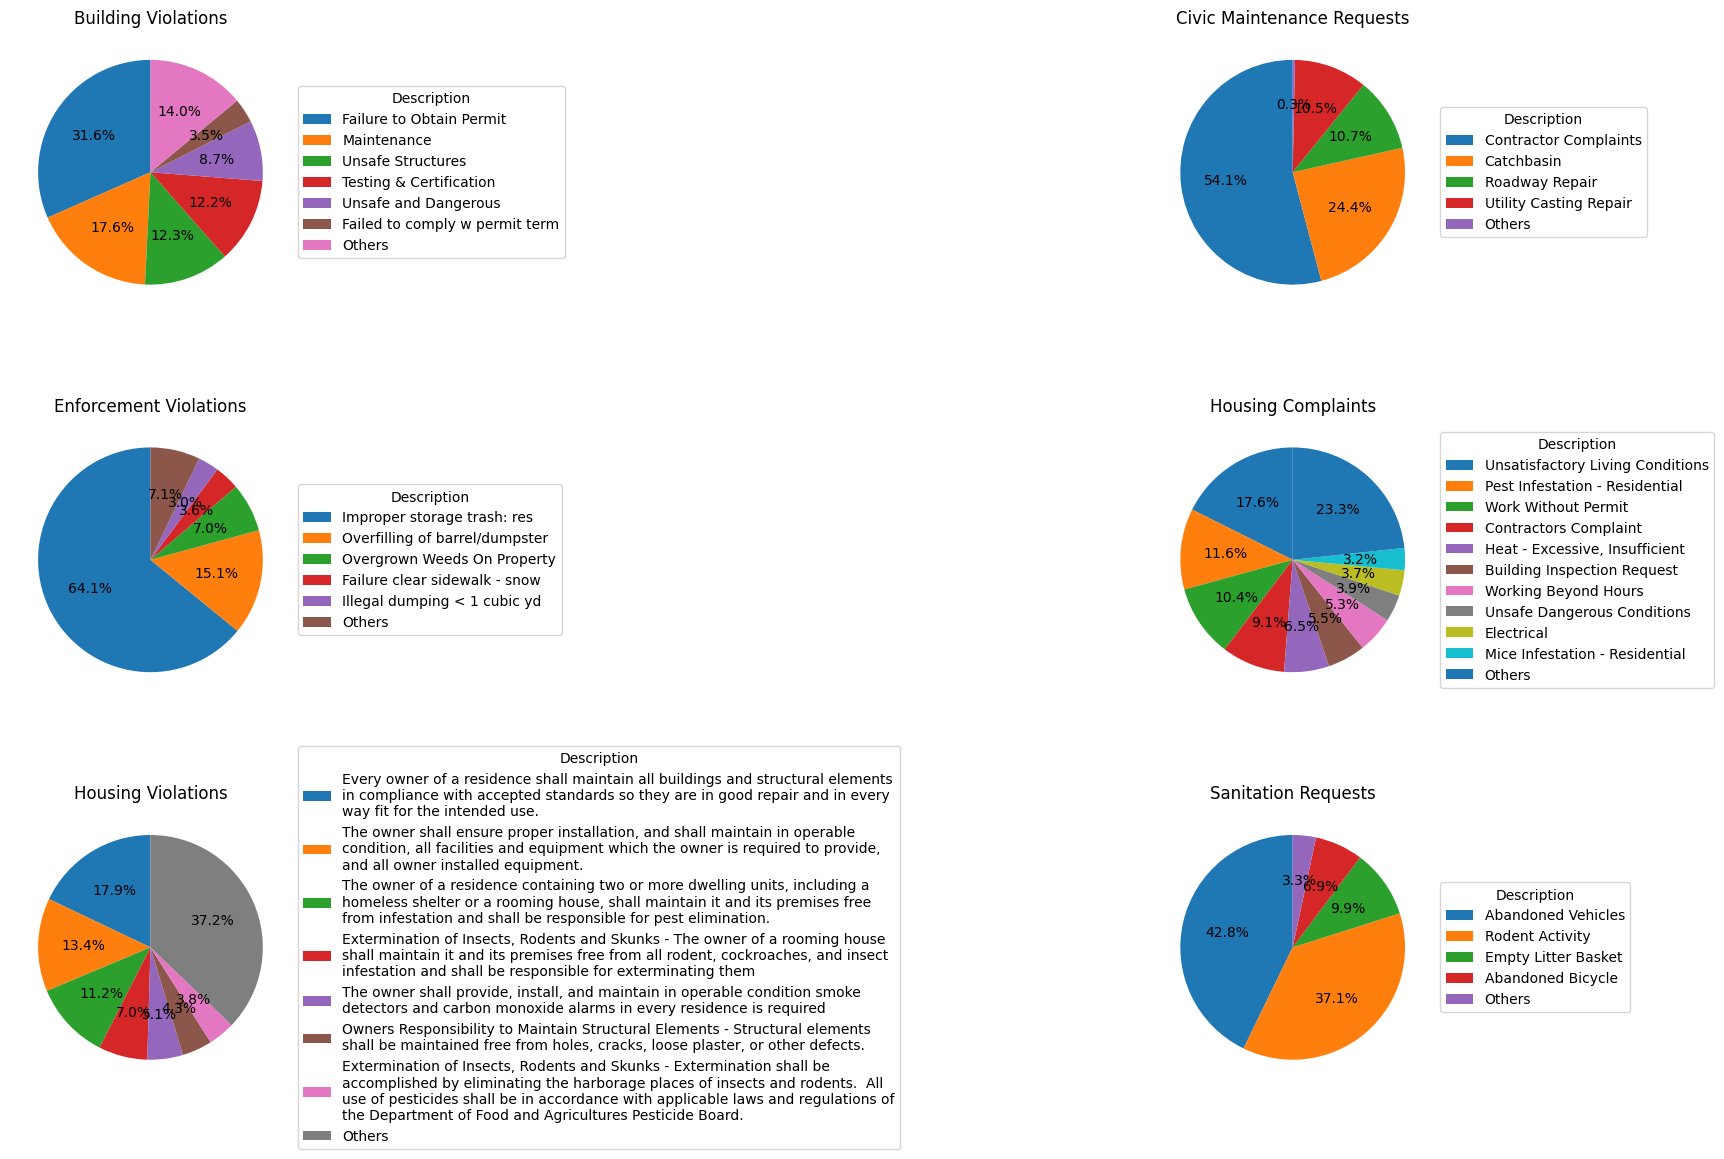

In [53]:
import matplotlib.pyplot as plt
import textwrap

# Function to wrap text for the legend
def wrap_labels(labels, width=80):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Get unique violation types
unique_violation_types = grouped_description["violation_type"].unique()

# Create subplots
fig, axes = plt.subplots(
    nrows=(len(unique_violation_types) + 1) // 2, ncols=2, figsize=(24, 12)
)
axes = axes.flatten()

# Plot a pie chart for each violation type
for ax, violation_type in zip(axes, unique_violation_types):
    data = grouped_description[grouped_description["violation_type"] == violation_type]
    wedges, texts, autotexts = ax.pie(
        data["percentage"],
        labels=None,  # Hide labels directly on the pie chart
        autopct="%1.1f%%",
        startangle=90,
        textprops={"fontsize": 10},
    )
    # Wrap legend labels
    wrapped_labels = wrap_labels(data["description"].tolist(), width=80)
    ax.set_title(f"{violation_type}", fontsize=12)
    ax.legend(
        wedges,
        wrapped_labels,
        title="Description",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize=10,
    )

plt.subplots_adjust(wspace=0, hspace=0.6)
plt.tight_layout()
plt.show()

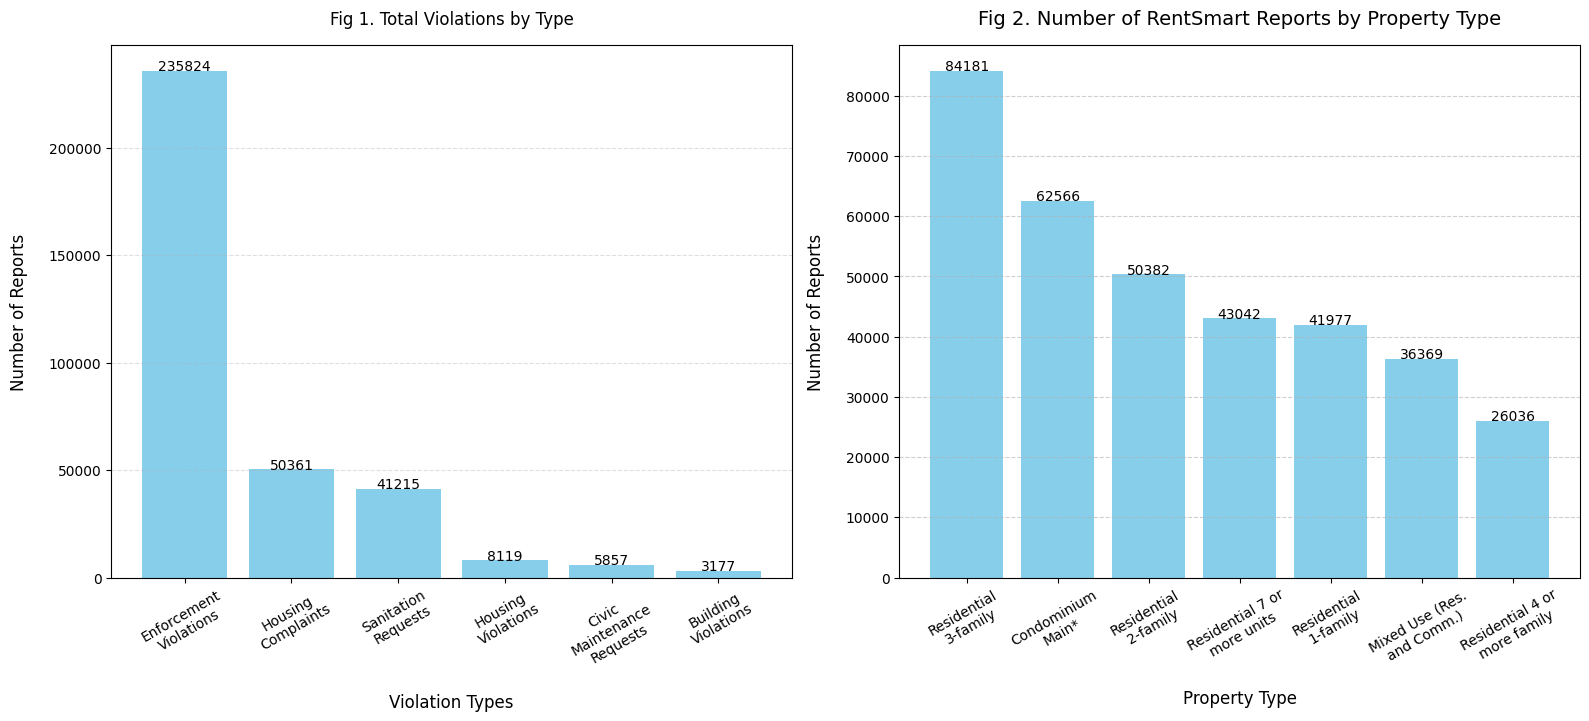

In [54]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import textwrap

violation_counts = df['violation_type'].value_counts()
property_type_counts = df['property_type'].value_counts()
description_counts = df.groupby("violation_type")["description"].value_counts().reset_index(name="count")
d7_catchment_area_counts = df['d7_catchment_area'].value_counts()

fig = plt.figure(figsize=(16, 18))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.6])

# First plot: Violation counts
ax1 = fig.add_subplot(gs[0, 0])
violation_counts_wrapped_labels = [
    '\n'.join(textwrap.wrap(label, width=16)) for label in violation_counts.index
]
ax1.bar(violation_counts.index, violation_counts, color='skyblue')
ax1.set_title('Fig 1. Total Violations by Type', fontsize=12, pad=15)
ax1.set_xlabel('Violation Types', fontsize=12, labelpad=15)
ax1.set_ylabel('Number of Reports', fontsize=12, labelpad=15)
ax1.set_xticks(range(len(violation_counts.index)))
ax1.set_xticklabels(violation_counts_wrapped_labels, rotation=30, ha='center', fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

for bar, height in zip(ax1.patches, violation_counts):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + 20,
        f'{int(height)}',
        ha='center',
        fontsize=10
    )

# Second plot: Property type counts
ax2 = fig.add_subplot(gs[0, 1])
property_type_counts_wrapped_labels = [
    '\n'.join(textwrap.wrap(label, width=16)) for label in property_type_counts.index
]
ax2.bar(property_type_counts.index, property_type_counts, color='skyblue')
ax2.set_title('Fig 2. Number of RentSmart Reports by Property Type', fontsize=14, pad=15)
ax2.set_xlabel('Property Type', fontsize=12, labelpad=15)
ax2.set_ylabel('Number of Reports', fontsize=12, labelpad=15)
ax2.set_xticks(range(len(property_type_counts.index)))
ax2.set_xticklabels(property_type_counts_wrapped_labels, rotation=30, ha='center', fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

for bar, height in zip(ax2.patches, property_type_counts):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height + 20,
        f'{int(height)}',
        ha='center',
        fontsize=10
    )

# Adjust layout
plt.tight_layout(h_pad=3)
plt.show()

**Summary:**

**Fig 1: Total Violations by Type**

The most frequent type of reports between 2019 to 2024 is enforcement violations, more than 4 times as frequent as the second and third most frequent type of reports, which is housing complaints and sanitation requests. Followed by housing violations, civic maintenance requests, and building violations.

### Percentage of violation types from 2019 to 2024

In [55]:
df['year'] = df['date'].dt.year
df_grouped = df.groupby(['year', 'violation_type']).size().unstack(fill_value=0)
df_percentages = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100

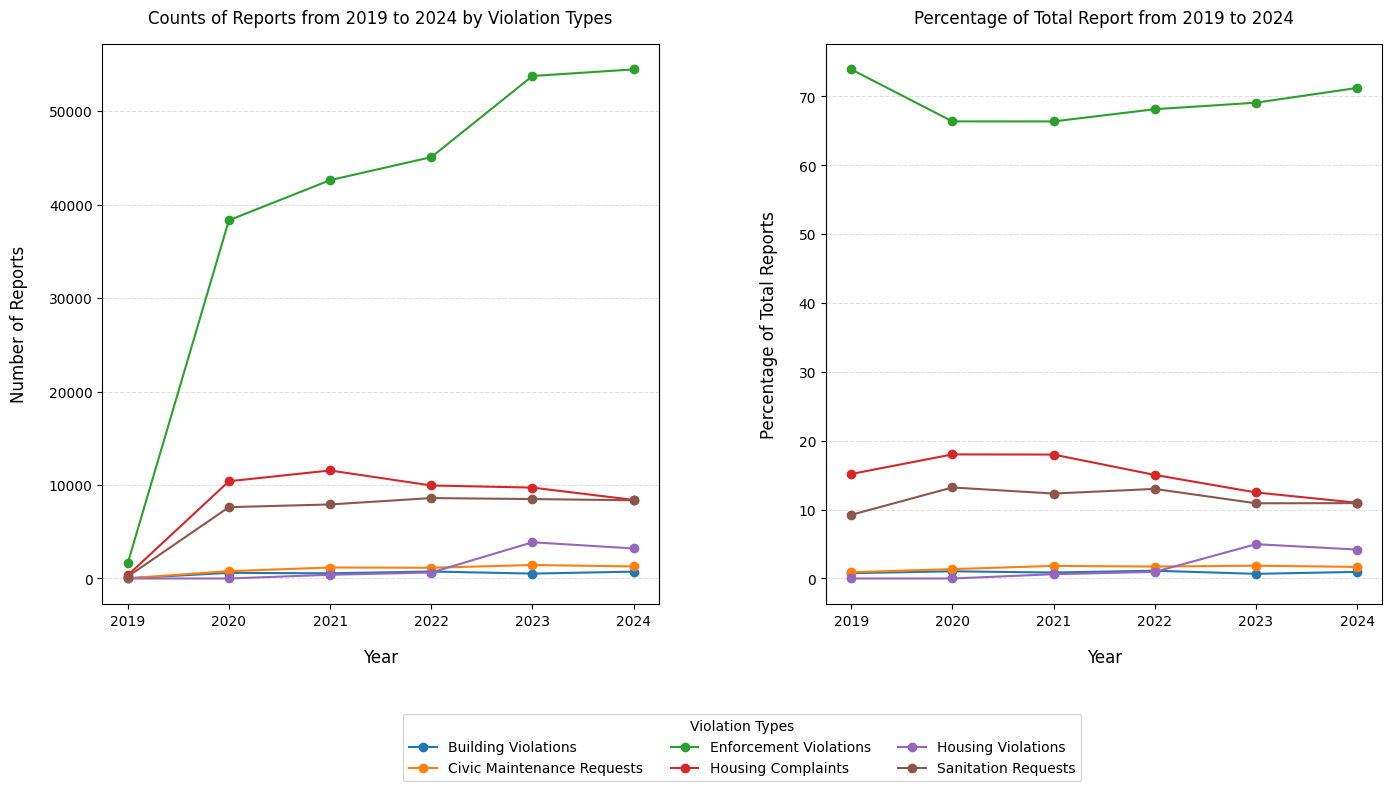

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

# First plot: Absolute counts of violations
axes[0].set_title('Counts of Reports from 2019 to 2024 by Violation Types', fontsize=12, pad=15)
for violation_type in df_grouped.columns:
    axes[0].plot(df_grouped.index, df_grouped[violation_type], marker="o", label=violation_type)
axes[0].set_xlabel('Year', fontsize=12, labelpad=15)
axes[0].set_ylabel('Number of Reports', fontsize=12, labelpad=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# Second plot: Percentage of violations
axes[1].set_title('Percentage of Total Report from 2019 to 2024', fontsize=12, pad=15)
for violation_type in df_percentages.columns:
    axes[1].plot(df_percentages.index, df_percentages[violation_type], marker="o", label=violation_type)
axes[1].set_xlabel('Year', fontsize=12, labelpad=15)
axes[1].set_ylabel('Percentage of Total Reports', fontsize=12, labelpad=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

handles, labels = axes[1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_handles_labels)

fig.legend(sorted_handles, sorted_labels, title="Violation Types", bbox_to_anchor=(0.5, -0.03), loc='lower center', ncol=3)


plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0.3)

plt.show()

**Summary:** The two graphs provide different perspectives on changes in violation type reports over time.
- The line graph on the left displays the raw counts of each violation type by year. However, because the total number of violations varies significantly between years (e.g., 2019 has far fewer reports than other years), comparing trends directly can be misleading.

- The line graph on the right illustrates the changes in violation types as a percentage of the total reports for each year. This normalization offers a clearer view of how the proportion of reports for each violation type has increased or decreased over time, independent of the overall number of reports.

### Number of RentSmart reports by property type

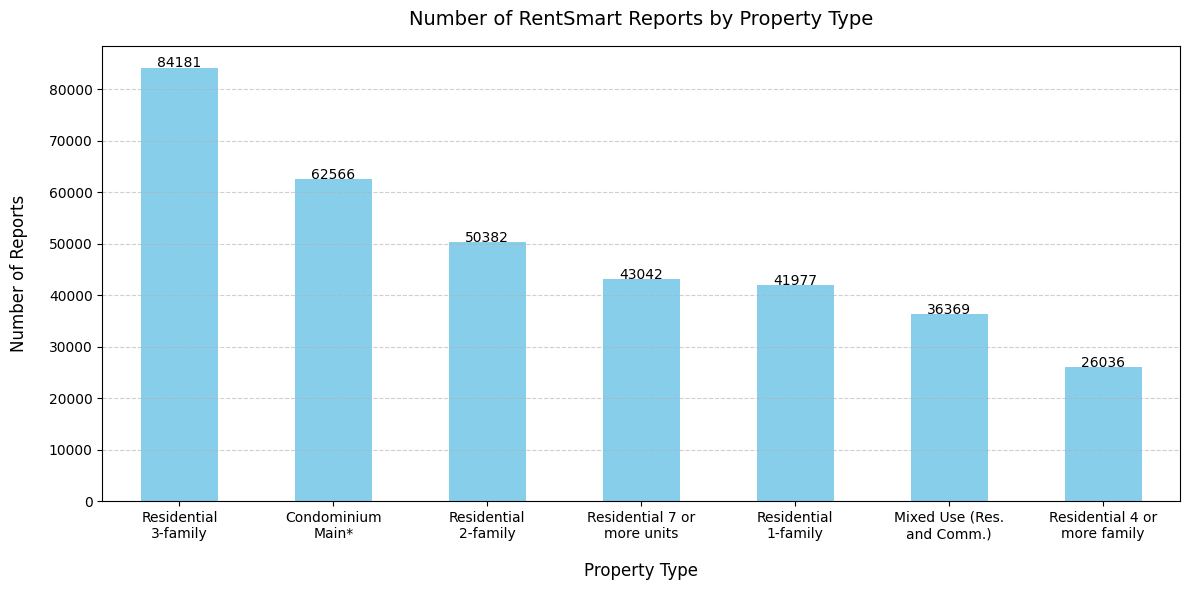

In [57]:
import textwrap

property_type_counts = df['property_type'].value_counts()

plt.figure(figsize=(12, 6))
ax = property_type_counts.plot(kind='bar', color='skyblue')

plt.title('Number of RentSmart Reports by Property Type', fontsize=14, pad=15)
plt.xlabel('Property Type', fontsize=12, labelpad=15)
plt.ylabel('Number of Reports', fontsize=12, labelpad=15)

wrapped_labels = [
    '\n'.join(textwrap.wrap(label, width=16)) for label in property_type_counts.index
]
ax.set_xticklabels(wrapped_labels, rotation=0, ha='center', fontsize=10)

plt.xticks(rotation=0, ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 20,
        f'{int(height)}',
        ha='center', fontsize=10
    )

plt.tight_layout()
plt.show()

**Summary:** Residential 3-family properties have the highest number of reports, with 84,181 reports. This indicates that such properties are the most common or face the most issues reported in the dataset. Condominium Main properties follow with 62,566 reports, showing they are another significant category for reporting. Reports are more common for multi-family and condominium properties than for single-family residential properties. This trend could reflect the complexity of managing larger or shared properties, which may lead to more frequent issues or violations.

### Violation type by property type

In [58]:
violation_by_property_counts = df.groupby(["violation_type", "property_type"]).size().unstack(fill_value=0)
percentages = violation_by_property_counts.div(violation_by_property_counts.sum(axis=1), axis=0) * 100

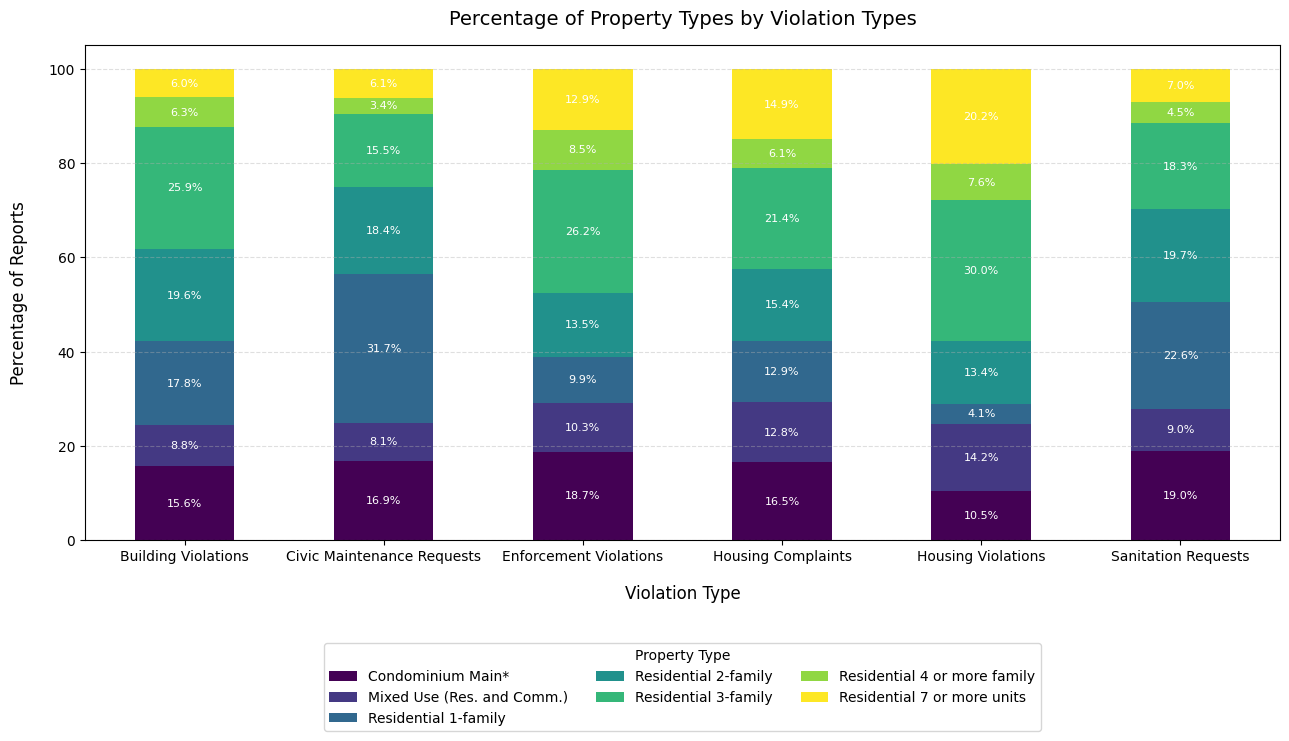

In [59]:
ax = percentages.plot(kind="bar", stacked=True, figsize=(13, 8), colormap="viridis")

plt.title("Percentage of Property Types by Violation Types", fontsize=14, pad=15)
plt.xlabel("Violation Type", fontsize=12, labelpad=15)
plt.ylabel("Percentage of Reports", fontsize=12, labelpad=15)
plt.xticks(rotation=0, ha="center", fontsize=10)
plt.legend(title="Property Type", bbox_to_anchor=(0.5, -0.4), loc="lower center", fontsize=10, ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.4)

for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{height:.1f}%',
                ha='center', va='center', fontsize=8, color='white'
            )

plt.tight_layout()
plt.show()

**Summary:** The stacked bar chart illustrates the distribution of property types within each violation type, providing insights into how different property categories contribute to the total reports for each type of violation. Residential 3-family properties have the highest total volume of reports across almost all violation types, followed by Condominium Main* and Residential 2-family properties.

## Conclusion


- Enforcement Violations has the highest number of violations from 2019 to 2024 and is gradually increasing every year. The second and third most common violation types are Housing Complaints, which has been consistently falling, and Sanitation Requests, which does't have much change across the recent years.

- Residential 3-family properties and condominiums are the most common property types that reported to RentSmart, which may also be one of the reason why it makes up more than 30% of every violation type.

- Housing Violations had a stark increase between 2022 and 2023 then decreased afterward. Considering the year, this increase may be due to COVID-19.